### a. Data Processing

In [80]:
import pandas as pd

df = pd.read_csv('data_train.csv')

print(df.head())
df.shape

   Unnamed: 0  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
0           0    -200.0       2.1          593.0    146.0        1212.0   
1           1    -200.0      11.0         1013.0    354.0         545.0   
2           2    -200.0       7.6          882.0    342.0         885.0   
3           3    -200.0      18.1         1243.0    481.0         599.0   
4           4    -200.0       7.3          869.0     71.0         953.0   

   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  PT08.S1(CO)  
0     72.0         984.0        494.0  10.8  49.7  0.6429        797.0  
1    141.0        1384.0       1287.0  17.4  50.6  0.9989       1282.0  
2    149.0         950.0        894.0   7.8  33.9  0.3594        891.0  
3    173.0        1815.0       1582.0  26.4  41.9  1.4237       1285.0  
4     77.0        1363.0        632.0  37.4  14.7  0.9295        892.0  


(6250, 13)

The data above consists of several predictor data sets from independent collectors. Our Target variable is PT08.s1(CO), we can use the data provided to determine the linear relationship between CO and each of the other provided variables.

In [81]:
# Check for missing values in the dataset
missing_values_count = df.isnull().sum()

# Drop rows with any missing data
df_cleaned = df.dropna()

# Check the shape after dropping missing values to see how many rows were dropped
cleaned_data_shape = df_cleaned.shape

missing_values_count, cleaned_data_shape

(Unnamed: 0        0
 NMHC(GT)         77
 C6H6(GT)         77
 PT08.S2(NMHC)    77
 NOx(GT)          77
 PT08.S3(NOx)     77
 NO2(GT)          77
 PT08.S4(NO2)     77
 PT08.S5(O3)      77
 T                77
 RH               77
 AH               77
 PT08.S1(CO)      77
 dtype: int64,
 (6173, 13))

In [82]:
# Extracting features and the label from the cleaned dataset
features = df_cleaned.drop(['PT08.S1(CO)', 'Unnamed: 0'], axis=1)  # Removing the target variable and the unnamed index column
label = df_cleaned['PT08.S1(CO)']  # Target variable

features.head(), label.head()


(   NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  \
 0    -200.0       2.1          593.0    146.0        1212.0     72.0   
 1    -200.0      11.0         1013.0    354.0         545.0    141.0   
 2    -200.0       7.6          882.0    342.0         885.0    149.0   
 3    -200.0      18.1         1243.0    481.0         599.0    173.0   
 4    -200.0       7.3          869.0     71.0         953.0     77.0   
 
    PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
 0         984.0        494.0  10.8  49.7  0.6429  
 1        1384.0       1287.0  17.4  50.6  0.9989  
 2         950.0        894.0   7.8  33.9  0.3594  
 3        1815.0       1582.0  26.4  41.9  1.4237  
 4        1363.0        632.0  37.4  14.7  0.9295  ,
 0     797.0
 1    1282.0
 2     891.0
 3    1285.0
 4     892.0
 Name: PT08.S1(CO), dtype: float64)

### Exploratory Data Analysis

A z-score standardization was applied to the data

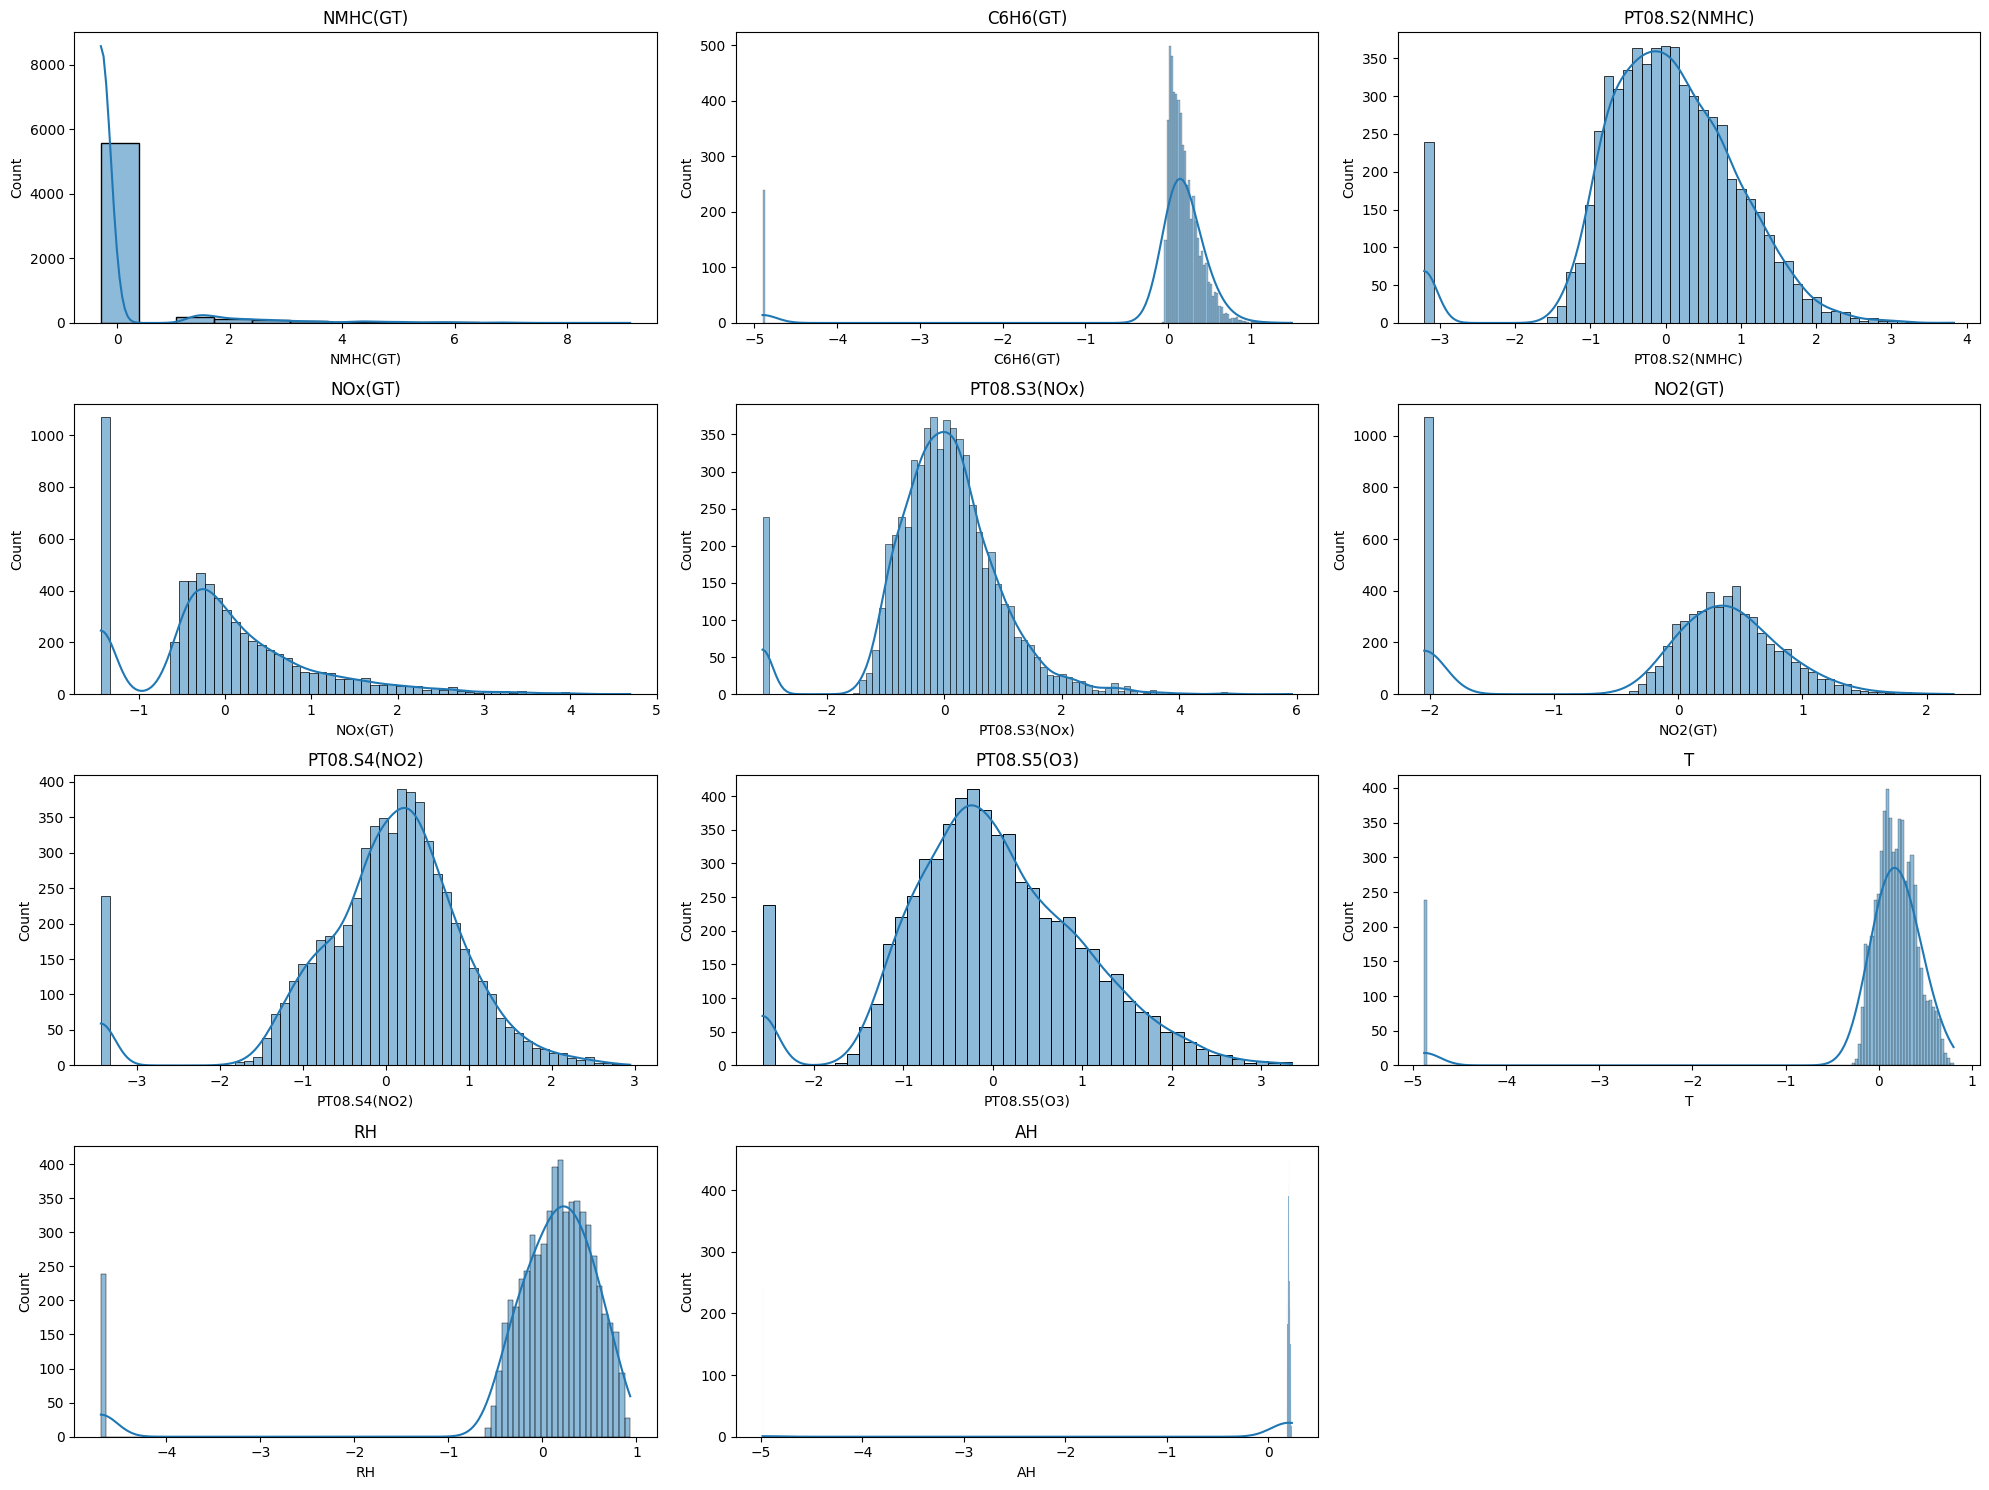

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the features
features = (features - features.mean()) / features.std()

# Plotting histograms for each feature
plt.figure(figsize=(20, 15))
for i, column in enumerate(features.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(features[column], kde=True)
    plt.title(column)
plt.tight_layout()


plt.show()


Many of the above histograms have distributions near the normal distribution. However, many of them contain several instances of the value -200, likely indicating some sort of null or sensor error value.

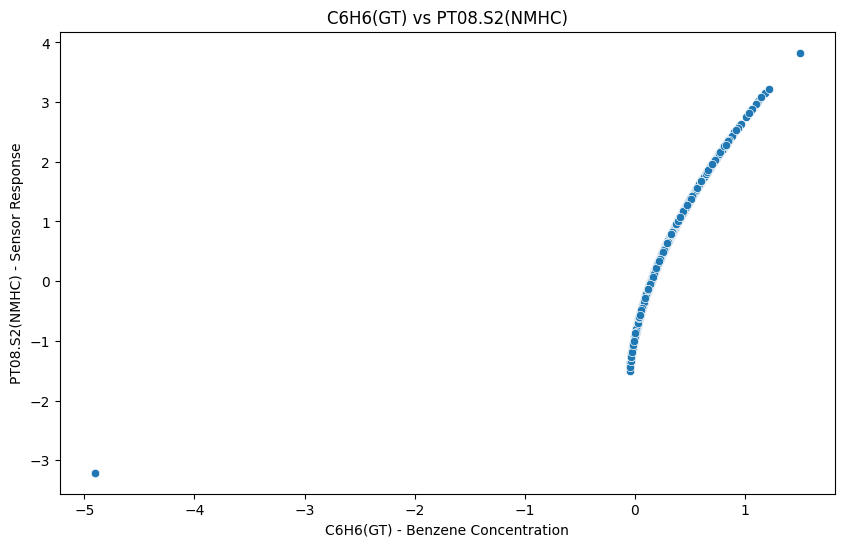

In [84]:
# Scatter plot for C6H6(GT) vs PT08.S2(NMHC)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features['C6H6(GT)'], y=features['PT08.S2(NMHC)'])
plt.title('C6H6(GT) vs PT08.S2(NMHC)')
plt.xlabel('C6H6(GT) - Benzene Concentration')
plt.ylabel('PT08.S2(NMHC) - Sensor Response')
plt.show()


#### Correlation
The above scatter plot shows a strong correlation between C6H6 and PT08.S2(NMHC). This indicates that there is some underlying physical reason for this relation ship. It also implys, that if we have enough data regarding this relationship we can model it fairly accurately.

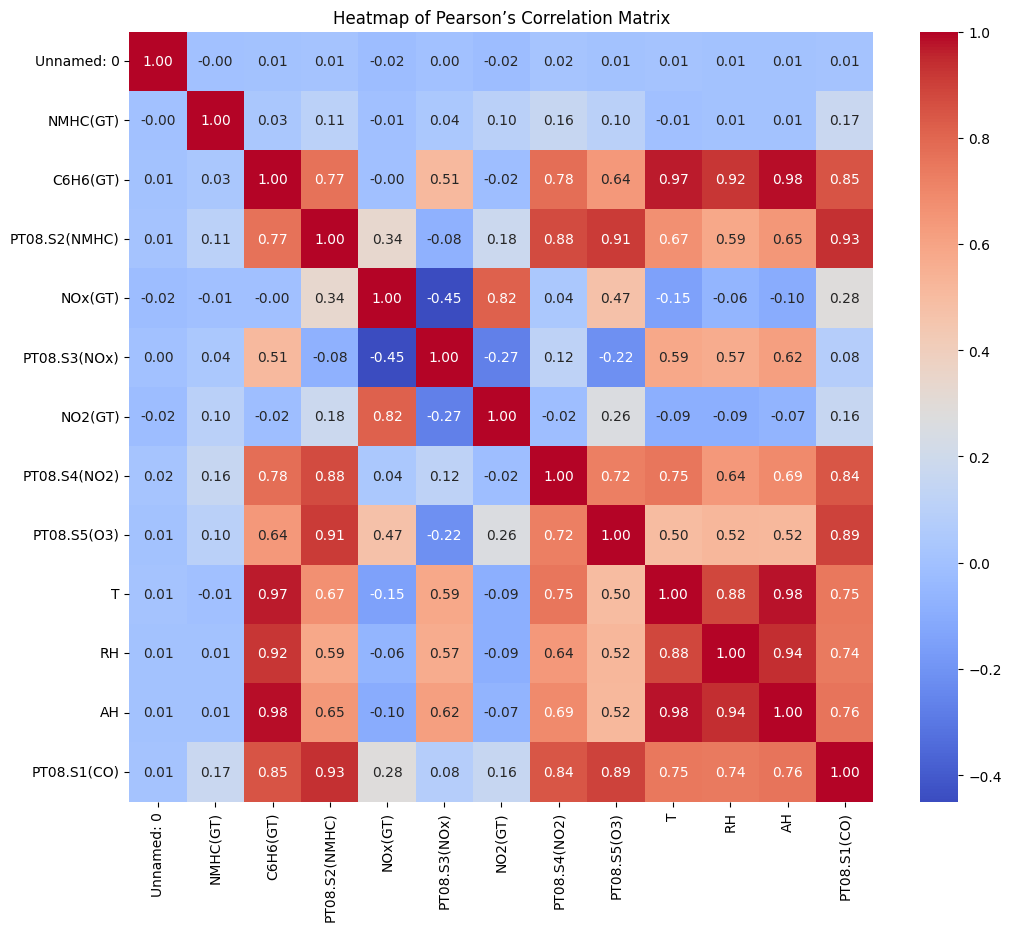

In [85]:
# Compute the Pearson's correlation matrix for the features
correlation_matrix = df_cleaned.corr()

# Visualizing the correlation matrix with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Pearson’s Correlation Matrix')
plt.show()


The above heatmap represents the strength of the correlation relationship between each pair of variables in the data set. Those with larger coefficients have stronger overall linear correlation.  

### d. Linear Regression

In [86]:
import numpy as np

class LinearRegression:
    def __init__(self, learning_rate=0.001, n_iterations=10000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
    
        for i in range(self.n_iterations):
            y_hat = np.dot(X, self.weights) + self.bias
            # gradient calculation
            dw = (1 / n_samples) * np.dot(X.T, (y_hat - y))
            db = (1 / n_samples) * np.sum(y_hat - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def forward(self, X):
        return np.dot(X, self.weights) + self.bias


In [87]:

lin_model = LinearRegression(learning_rate=0.001, n_iterations=10000)
lin_model.fit(features.values, label.values)

predictions = lin_model.forward(features.values)
print(predictions)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


mae = mean_absolute_error(label.values, predictions)
mse = mean_squared_error(label.values, predictions)
rmse = np.sqrt(mse)  # or mse**(0.5)
r2 = r2_score(label.values, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")



[ 817.67536098 1201.33972727  999.36065522 ...  912.75409497  956.4200413
 1351.33146157]
Mean Absolute Error (MAE): 55.04189810001795
Mean Squared Error (MSE): 5184.233111217862
Root Mean Squared Error (RMSE): 72.00161880970359
R-squared (R²): 0.9525046783364377


### e. Result Analysis: Linear Regression


In [88]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []


for i, j in kf.split(features):
    X_train, X_val = features.values[i], features.values[j]
    y_train, y_val = label.values[i], label.values[j]
    
    model = LinearRegression(learning_rate=0.001, n_iterations=10000)
    model.fit(X_train, y_train)
    predictions = model.forward(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    rmse_scores.append(rmse)

average_rmse = np.mean(rmse_scores)
print(f"Average RMSE: {average_rmse}") 
std_dev_rmse = np.std(rmse_scores)
print(f"Standard Deviation of RMSE: {std_dev_rmse}")

coefficients = model.weights
intercept = model.bias

feature_importance = sorted(zip(features.columns, coefficients), key=lambda x: abs(x[1]), reverse=True)
print("Feature Importance ranking: ")
for feature, coef in feature_importance:
    print(f"{feature}: {coef}")


Average RMSE: 72.03604290008485
Standard Deviation of RMSE: 1.8084823741500262
Feature Importance ranking: 
PT08.S5(O3): 98.22991838206777
PT08.S2(NMHC): 76.03455537228375
RH: 54.178485995293975
C6H6(GT): 50.71116945077997
AH: 36.59588577763547
NMHC(GT): 33.70335165907712
PT08.S3(NOx): -31.97975424848936
PT08.S4(NO2): 28.920374258009506
NOx(GT): 22.409277616893377
T: 15.136506910007968
NO2(GT): -7.5814879671003474


We do not see a big change across different folds with a relatively low standard deviation of 1.808

### f. Logistic Regression Implementation

In [89]:

df_cleaned = df_cleaned.copy()
df_cleaned['binary_label'] = (df_cleaned['PT08.S1(CO)'] > 1000).astype(int)
features = df_cleaned.drop(['PT08.S1(CO)', 'Unnamed: 0', 'binary_label'], axis=1)  # Removing the target variable and the unnamed index column
features = (features - features.mean()) / features.std()
label = df_cleaned['binary_label']  # Target variable


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class CustomLogisticRegression:
    def __init__(self, learning_rate=0.001, n_iterations=10000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.n_iterations):
            model = np.dot(X, self.weights) + self.bias
            y_predicted = sigmoid(model)
            
            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


    def forward(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return y_predicted_cls
    


### f. Result Analysis: Logistic Regression

In [90]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for i,j in kf.split(features):
    X_train, X_test = features.iloc[i], features.iloc[j]
    y_train, y_test = label.iloc[i], label.iloc[j]
    
    model = CustomLogisticRegression(learning_rate=0.001, n_iterations=10000)
    model.fit(X_train.values, y_train.values)
    predictions = model.forward(X_test.values)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate average and standard deviation for each metric
average_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

average_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)

average_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

average_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

# Output formatted results
print(f'Accuracy: {average_accuracy} ± {std_accuracy}')
print(f'Precision: {average_precision} ± {std_precision}')
print(f'Recall: {average_recall} ± {std_recall}')
print(f'F1 Score: {average_f1} ± {std_f1}')



Accuracy: 0.8982659991207292 ± 0.007985140704008796
Precision: 0.9302528626039782 ± 0.00330118821101214
Recall: 0.8987891921056036 ± 0.014480957462776322
F1 Score: 0.9141939058994302 ± 0.008017100503163234


#### g. ROC Curve - Logistic Regression

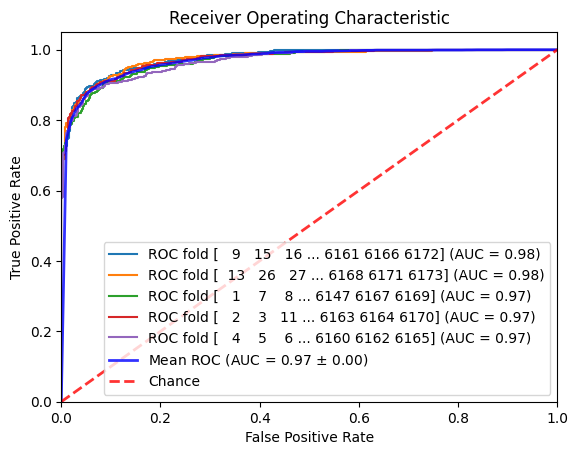

([0.9758824104553009,
  0.9750934660635513,
  0.96997542997543,
  0.9731381034893365,
  0.967786528264803],
 {'Accuracy': (0.9022342010118176, 0.009076844492064104),
  'Precision': (0.9258192629762005, 0.00879632809423971),
  'Recall': (0.9111322603996722, 0.016535716626750258),
  'F1 Score': (0.9183009839761394, 0.008578558688265748)})

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc


df_cleaned = df_cleaned.copy()
df_cleaned['binary_label'] = (df_cleaned['PT08.S1(CO)'] > 1000).astype(int)
labels = df_cleaned['binary_label']
features = df_cleaned.drop(['PT08.S1(CO)', 'Unnamed: 0', 'binary_label'], axis=1)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize model
model = LogisticRegression(solver='liblinear')  

# Lists to store results
auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()

# Perform 5-fold cross validation
for i, (i, i) in enumerate(kf.split(features, labels)):
    X_train, X_test = features.values[i], features.values[i]
    y_train, y_test = labels.values[i], labels.values[i]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[::,1]

    # Compute ROC curve AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)
    
    # TP rates
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    
    # Plot ROC curve for the current fold
    ax.plot(fpr, tpr, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
metrics = {
    'Accuracy': (np.mean(accuracy_scores), np.std(accuracy_scores)),
    'Precision': (np.mean(precision_scores), np.std(precision_scores)),
    'Recall': (np.mean(recall_scores), np.std(recall_scores)),
    'F1 Score': (np.mean(f1_scores), np.std(f1_scores))
}

# Plot the average ROC curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(auc_scores)
ax.plot(mean_fpr, mean_tpr, color='blue',
        label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05], title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc_scores, metrics


The results obtained using the sklearn logistic regression packeage were more accurate than those obtained by my custom class. However, both models had relatively high rates of accuracy with low standard deviations.

### h. Inference

In [92]:
training_df = pd.read_csv('data_train.csv')
testing_df = pd.read_csv('data_test.csv')

# Drop rows with any missing data
training_df = training_df.dropna()
testing_df = testing_df.dropna()

y_train = training_df['PT08.S1(CO)']
y_train_logistic = (training_df['PT08.S1(CO)'] > 1000).astype(int)


X_train = training_df.drop(['PT08.S1(CO)', 'Unnamed: 0'], axis=1) 
X_test = testing_df.drop(['Unnamed: 0'], axis=1)  


X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

# Train the linear model
linear_model = LinearRegression(learning_rate=0.001, n_iterations=10000)
linear_model.fit(X_train.values, y_train.values)

# Train the logistic model on the binary labels
logistic_model = CustomLogisticRegression(learning_rate=0.001, n_iterations=10000)
logistic_model.fit(X_train.values, y_train_logistic.values)

# Make predictions
linear_pred = linear_model.forward(X_test.values)
logistic_pred = logistic_model.forward(X_test.values)

# Prepare the DataFrame with predictions
pred_df = pd.DataFrame({'pred_linear': linear_pred, 'pred_logistic': logistic_pred})
pred_df.to_csv('predictions.csv', index=False)


